# **Rice Plant Disease Classification using CNN Transfer Learning**
___

In [1]:
trainpath= 'D:/Final/Splitted Datasets/train'
validpath='D:/Final/Splitted Datasets/val'
testpath='D:/Final/Splitted Datasets/test'

In [2]:
img_width, img_height = (224,224)

In [3]:
batch_size = 20

## Data Augumentation 
- To balance the dataset and to increase the size of training and testing dataset
- Regularization technique to minimize overfitting
- Rescaling the image is Normalizing the image

In [4]:
import scipy

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input


In [6]:
train_data_generator= ImageDataGenerator(
        #rotation_range=350,
        preprocessing_function=preprocess_input 
    )

train_set = train_data_generator.flow_from_directory(
        trainpath,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='categorical'
    )

valid_data_generator = ImageDataGenerator(
        preprocessing_function=preprocess_input
    )

valid_set = valid_data_generator.flow_from_directory(
        validpath,
        target_size=(img_width,img_height),
        batch_size=batch_size,
        class_mode='categorical', 
        shuffle=False 
    )

test_data_generator= ImageDataGenerator()

test_set = test_data_generator.flow_from_directory(
        testpath,
        target_size=(img_width,img_height),
        batch_size=batch_size, 
        class_mode='categorical', 
        shuffle=False
    )

Found 8734 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 1091 images belonging to 11 classes.


In [7]:
# To print number of batches per epoch
print('Number of Batches per epoch train=%d, valid=%d ,test=%d' % (len(train_set), len(valid_set),len(test_set)))

Number of Batches per epoch train=437, valid=55 ,test=55


## Transfer Learning

In [8]:
from tensorflow.keras.applications.vgg16 import VGG16

In [9]:
base_model = VGG16(
        input_shape = (img_width, img_height, 3), 
        include_top = False, 
        weights = 'imagenet'
    )

In [10]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Layers

In [11]:
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import keras

In [12]:
x = base_model.output
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(base_model.output)
x = keras.layers.Dense(1024, activation='relu')(x)

x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(512, activation='relu')(x)

x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(train_set.num_classes, activation='softmax')(x)

for layer in base_model.layers[:-100]:
   layer.trainable = False

model = tf.keras.models.Model(base_model.input, x)

model.compile(
        optimizer = Adam(learning_rate=0.000001), 
        loss = 'categorical_crossentropy', 
        metrics = ['acc']
    )

In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

## Train the Model

In [14]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [15]:
saved_model = "D:/Final/Model/Rice_VGG16_50epochs.h5"

In [16]:
# Saving the model according to the conditions  
checkpoint = ModelCheckpoint(
        saved_model, 
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        mode='auto'
    )

reduce = ReduceLROnPlateau(
        monitor='val_loss', 
        verbose=1, 
        factor=0.1, 
        patience=2, 
        mode='auto'
    )


In [17]:
epochs = 50

In [18]:
# Train the model
trained_model = model.fit(
        train_set,
        steps_per_epoch = train_set.samples//train_set.batch_size,
        epochs = epochs,
        validation_data = valid_set,
        validation_steps = valid_set.samples//valid_set.batch_size,
        callbacks=[checkpoint,reduce]
    )


Epoch 1/50
150/436 [=========>....................] - ETA: 31:26 - loss: 10.7904 - acc: 0.0967

c:\Users\MCCLAB13\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\Image.py:992: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


436/436 [==============================] - ETA: 0s - loss: 6.7891 - acc: 0.1031
Epoch 1: val_loss improved from inf to 2.41842, saving model to D:/Final/Model\Rice_VGG16_50epochs.h5
436/436 [==============================] - 4340s 10s/step - loss: 6.7891 - acc: 0.1031 - val_loss: 2.4184 - val_acc: 0.1667 - lr: 1.0000e-06
Epoch 2/50
436/436 [==============================] - ETA: 0s - loss: 2.9945 - acc: 0.1213
Epoch 2: val_loss improved from 2.41842 to 2.20569, saving model to D:/Final/Model\Rice_VGG16_50epochs.h5
436/436 [==============================] - 2892s 7s/step - loss: 2.9945 - acc: 0.1213 - val_loss: 2.2057 - val_acc: 0.2222 - lr: 1.0000e-06
Epoch 3/50
436/436 [==============================] - ETA: 0s - loss: 2.5332 - acc: 0.1434
Epoch 3: val_loss improved from 2.20569 to 2.14295, saving model to D:/Final/Model\Rice_VGG16_50epochs.h5
436/436 [==============================] - 2908s 7s/step - loss: 2.5332 - acc: 0.1434 - val_loss: 2.1430 - val_acc: 0.2806 - lr: 1.0000e-06
Epo

In [56]:
model.save("vgg1650")
model.save("vgg1650.h5")

s = model.to_json()
with open('vgg16_model.json', 'w') as f:
    f.write(s)

model.save_weights("vgg1650weights.h5")
model.save_weights("vgg1650weights")

INFO:tensorflow:Assets written to: vgg1650\assets


INFO:tensorflow:Assets written to: vgg1650\assets


In [19]:
training_accuracy      = trained_model.history['acc'][-1]
training_loss          = trained_model.history['loss'][-1]
validation_accuracy    = trained_model.history['val_acc'][-1]
validation_loss       = trained_model.history['val_loss'][-1]
print("Training Accuracy   :", training_accuracy )
print("Training Loss       :", training_loss)
print("Validation Accuracy :", validation_accuracy)
print("Validation Loss     :", validation_loss)

Training Accuracy   : 0.9594904780387878
Training Loss       : 0.11485287547111511
Validation Accuracy : 0.9462962746620178
Validation Loss     : 0.18498916923999786


## Loss and Accuracy Visualization

In [20]:
import matplotlib.pyplot as plt

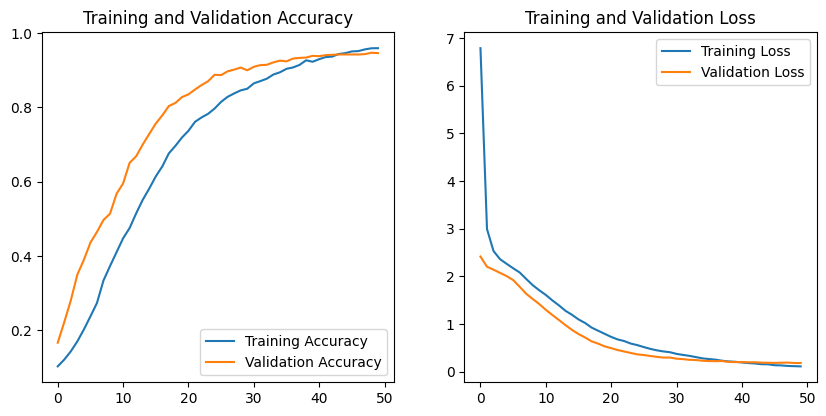

In [22]:
acc = trained_model.history['acc']
val_acc = trained_model.history['val_acc']
loss = trained_model.history['loss']
val_loss = trained_model.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Load Model

In [23]:
import tensorflow as tf
new_model = tf.keras.models.load_model(saved_model)


In [24]:
predict = new_model.predict(
        test_set,
        steps=len(test_set),
        verbose=1
    )

55/55 [==============================] - 86s 2s/step


In [25]:
predict

array([[9.99723494e-01, 1.28794181e-05, 9.44764409e-08, ...,
        2.72943806e-10, 4.05885778e-08, 2.78547546e-10],
       [1.89550258e-02, 3.27504091e-02, 4.97962981e-02, ...,
        1.48144807e-03, 3.14157945e-03, 1.43949345e-01],
       [1.74166623e-03, 9.93063629e-01, 4.02785512e-03, ...,
        6.40935559e-06, 5.58030675e-04, 6.38609417e-05],
       ...,
       [1.17348256e-02, 1.67424884e-02, 3.47358827e-03, ...,
        9.05341469e-04, 1.87264901e-04, 7.29635000e-01],
       [5.28780575e-08, 1.79725979e-09, 1.64910408e-09, ...,
        1.27815180e-11, 1.88388927e-09, 5.46637686e-08],
       [1.34446445e-05, 3.81870322e-08, 1.41269811e-06, ...,
        6.12585893e-09, 5.08042408e-09, 3.11838230e-04]], dtype=float32)

In [26]:
import numpy as np

In [27]:
rounded_predictions = np.argmax(predict,axis=-1)

In [28]:
rounded_predictions

array([ 0,  5,  1, ..., 10,  5,  5], dtype=int64)

In [29]:
rounded_predictions.shape

(1091,)

In [30]:
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt

In [31]:
test_set.class_indices

{'Bacterial_Blight': 0,
 'Blast': 1,
 'Brown_Spot': 2,
 'False_Smut': 3,
 'Healthy': 4,
 'Healthy_Flowers': 5,
 'Hispa': 6,
 'Leaf_Smut': 7,
 'Sheath_Blight': 8,
 'Tungro': 9,
 'Unhealthy_Flowers': 10}

In [32]:
test_labels=test_set.classes

In [33]:
test_labels.shape

(1091,)

In [34]:
cm = confusion_matrix(y_true=test_labels, y_pred=rounded_predictions)
cm

array([[74, 14,  4,  1,  0,  6,  1,  0,  0,  0,  0],
       [ 2, 77, 16,  0,  0,  0,  3,  0,  0,  2,  0],
       [ 1, 15, 74,  1,  0,  0,  6,  3,  0,  0,  0],
       [ 0,  2,  0, 86,  0, 11,  0,  0,  0,  0,  1],
       [ 0,  0,  1,  0, 88,  1,  0,  0,  0,  4,  0],
       [ 1,  0,  0,  6,  1, 90,  0,  0,  0,  0,  2],
       [ 1, 27,  4,  0,  1,  3, 61,  0,  0,  0,  0],
       [ 0,  2,  2,  0,  0,  0,  1, 95,  0,  0,  0],
       [ 8,  3,  1, 14,  1, 17,  1,  2, 23,  2, 28],
       [ 0,  3,  2,  2,  1,  1,  0,  0,  4, 87,  0],
       [ 0,  0,  0,  4,  1, 70,  0,  0,  0,  0, 25]], dtype=int64)

In [35]:
class_list = []
for keys in test_set.class_indices.keys():
    class_list.append(keys)

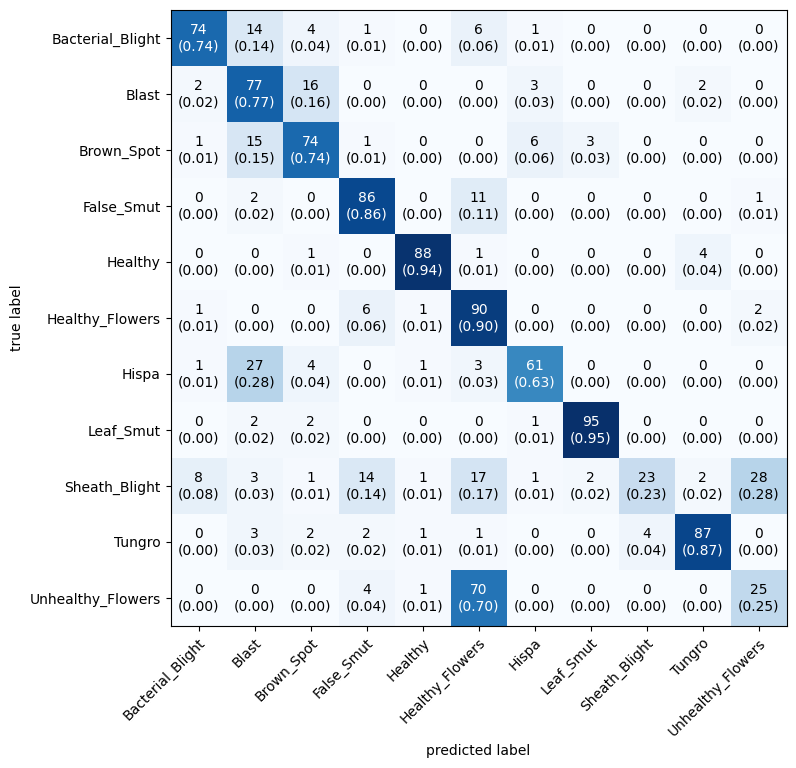

In [37]:
fig,ax=plot_confusion_matrix(conf_mat=cm,figsize=(8,8),show_normed=True, class_names=class_list)
plt.show()


In [38]:
print('test accuracy: {0:2f}'.format((np.diagonal(cm).sum()/cm.sum().sum()*100)))

test accuracy: 71.494042


Other Plotting Library

<AxesSubplot:>

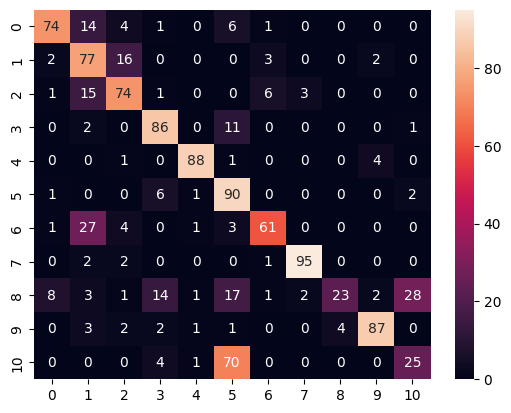

In [39]:
import seaborn as sns
sns.heatmap(cm, annot=True)

<AxesSubplot:>

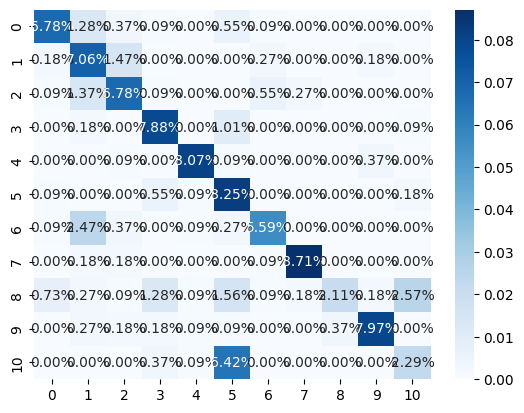

In [40]:
sns.heatmap(
        cm/np.sum(cm), 
        annot=True, 
        fmt='.2%', 
        cmap='Blues'
    )

---

In [41]:
import sklearn.metrics as metrics

In [42]:
class_list = []
for keys in test_set.class_indices.keys():
    class_list.append(keys)

class_list

['Bacterial_Blight',
 'Blast',
 'Brown_Spot',
 'False_Smut',
 'Healthy',
 'Healthy_Flowers',
 'Hispa',
 'Leaf_Smut',
 'Sheath_Blight',
 'Tungro',
 'Unhealthy_Flowers']

In [43]:

classify_report = metrics.classification_report(
        y_true=test_labels, 
        y_pred=rounded_predictions,
        target_names=class_list
    )

print('classify_report : \n', classify_report)


classify_report : 
                    precision    recall  f1-score   support

 Bacterial_Blight       0.85      0.74      0.79       100
            Blast       0.54      0.77      0.63       100
       Brown_Spot       0.71      0.74      0.73       100
       False_Smut       0.75      0.86      0.80       100
          Healthy       0.95      0.94      0.94        94
  Healthy_Flowers       0.45      0.90      0.60       100
            Hispa       0.84      0.63      0.72        97
        Leaf_Smut       0.95      0.95      0.95       100
    Sheath_Blight       0.85      0.23      0.36       100
           Tungro       0.92      0.87      0.89       100
Unhealthy_Flowers       0.45      0.25      0.32       100

         accuracy                           0.71      1091
        macro avg       0.75      0.72      0.70      1091
     weighted avg       0.75      0.71      0.70      1091



In [44]:
overall_accuracy = metrics.accuracy_score(
        y_true=test_labels, 
        y_pred=rounded_predictions
    )
acc_for_each_class = metrics.precision_score(
        y_true=test_labels, 
        y_pred=rounded_predictions, 
        average=None
    )
average_accuracy = np.mean(acc_for_each_class)
score = metrics.accuracy_score(
        y_true=test_labels, 
        y_pred=rounded_predictions
    )

print('ac_for_each_class : \n', acc_for_each_class)
print('average_accuracy: {0:2f}'.format(average_accuracy))
print('overall_accuracy: {0:2f}'.format(overall_accuracy))
print('score: {0:f}'.format(score))

ac_for_each_class : 
 [0.85057471 0.53846154 0.71153846 0.75438596 0.94623656 0.45226131
 0.83561644 0.95       0.85185185 0.91578947 0.44642857]
average_accuracy: 0.750286
overall_accuracy: 0.714940
score: 0.714940


ROC Curve

In [45]:
from sklearn.metrics import roc_curve

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(test_labels, predict[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(test_labels))]
p_fpr, p_tpr, _ = roc_curve(test_labels, random_probs, pos_label=1)

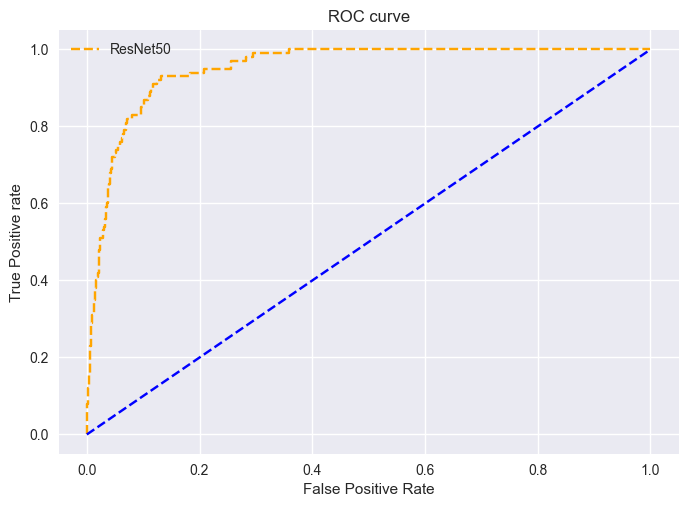

In [46]:
# matplotlib
import matplotlib.pyplot as plt
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='ResNet50')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

ROC Area Under Curve (AUC) Score

In [47]:
from sklearn.metrics import roc_auc_score

# auc scores
# auc_score1 = roc_auc_score(test_labels, predict[:,1])
auc_score1 = roc_auc_score(y_score=predict, y_true=test_labels, multi_class="ovr",average=None)

ind = 0
for score in auc_score1:
    print("%s : %.3f" % (class_list[ind], score))
    ind += 1

Bacterial_Blight : 0.978
Blast : 0.951
Brown_Spot : 0.946
False_Smut : 0.977
Healthy : 0.998
Healthy_Flowers : 0.944
Hispa : 0.966
Leaf_Smut : 0.998
Sheath_Blight : 0.953
Tungro : 0.997
Unhealthy_Flowers : 0.796


---
Model Implementation
---

---

(1, 224, 224, 3)


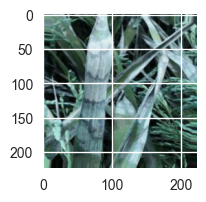

In [49]:
import cv2
import numpy as np
image=cv2.imread("D:/Testing/sheathblight (2).jpg")
#image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_resized=cv2.resize(image, (img_width, img_height))
image=np.expand_dims(img_resized,axis=0)
print(image.shape)

plt.figure(figsize = (2,2))
plt.imshow(img_resized)
plt.show()

In [50]:
prediction = new_model.predict(image)
print(prediction)

1/1 [==============================] - 0s 269ms/step
[[3.5348132e-02 1.3558746e-04 2.2974217e-04 6.4770305e-05 1.6410720e-05
  9.1387832e-01 4.5127872e-05 5.9180184e-05 1.5871822e-04 1.7739667e-05
  5.0046202e-02]]


In [51]:
class_output = class_list[np.argmax(prediction)]
print(class_output)

Healthy_Flowers


In [52]:
predicted_acuracy = ("{:.2%}".format(np.array(prediction[0])[np.argmax(prediction)]))
print(predicted_acuracy)

91.39%


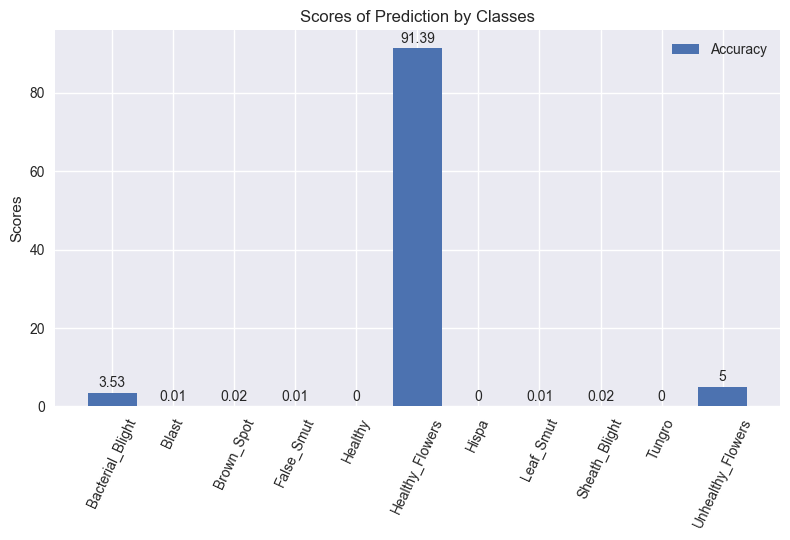

In [53]:
import matplotlib.pyplot as plt
import numpy as np

labels = class_list
values = list(np.array(np.around(prediction[0] * 100,2)))

x = np.arange(len(labels))  # the label locations
width = 0.80  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x, values, width, label='Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores of Prediction by Classes')
ax.set_xticks(x, labels)
plt.xticks(rotation=65)
ax.legend()

ax.bar_label(rects1, padding=2)

fig.tight_layout()

plt.show()

---

1/1 [==============================] - 0s 102ms/step


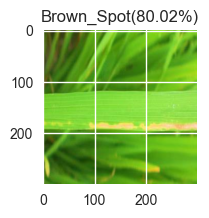

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 109ms/step


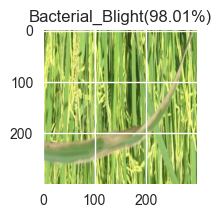

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 111ms/step


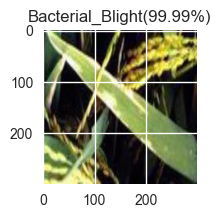

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 106ms/step


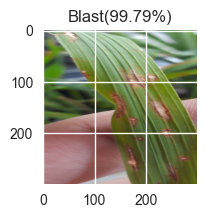

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 105ms/step


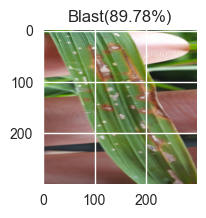

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 103ms/step


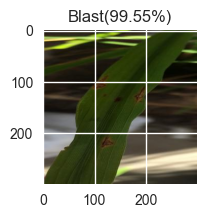

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 105ms/step


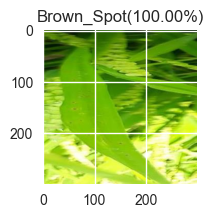

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 105ms/step


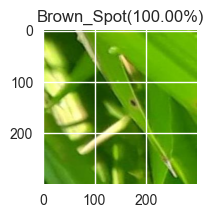

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 103ms/step


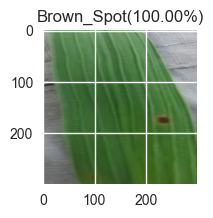

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 103ms/step


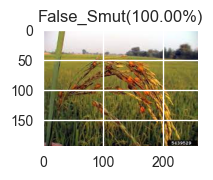

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 104ms/step


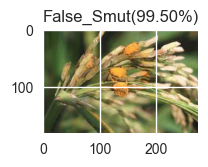

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 102ms/step


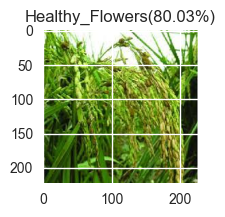

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 101ms/step


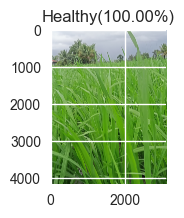

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 101ms/step


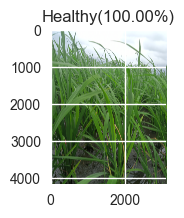

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 100ms/step


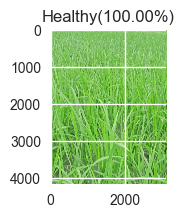

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 106ms/step


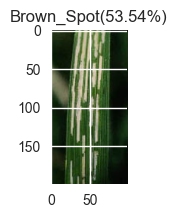

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 102ms/step


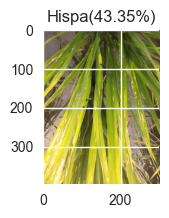

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 107ms/step


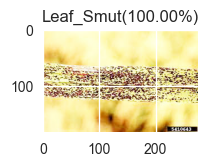

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 139ms/step


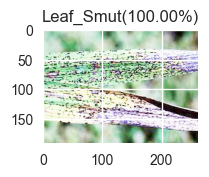

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 110ms/step


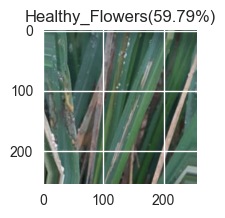

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 102ms/step


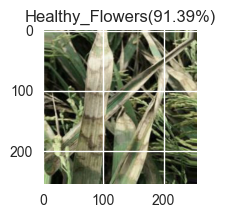

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 103ms/step


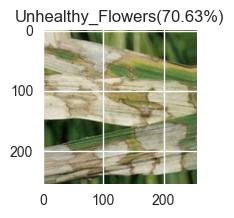

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 107ms/step


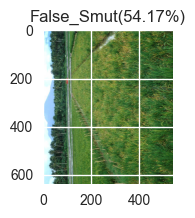

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 103ms/step


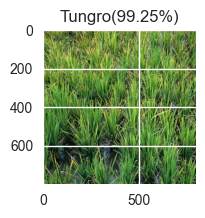

----------------------------------------------------------------------------------
1/1 [==============================] - 0s 104ms/step


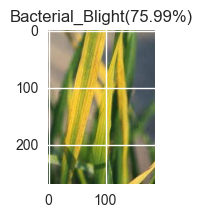

----------------------------------------------------------------------------------


In [54]:
import os
import cv2
import numpy as np
path = "D:/Testing"
for img in os.listdir(path):
    try:
        image = cv2.imread(os.path.join(path, img))
        #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_resized=cv2.resize(image, (img_width, img_height))
        new_image=np.expand_dims(img_resized,axis=0)
        # print(image.shape)

        prediction = new_model.predict(new_image)

        class_output = class_list[np.argmax(prediction)]
        #print(class_output)
        predicted_acuracy = ("{:.2%}".format(np.array(prediction[0])[np.argmax(prediction)]))
        #print(predicted_acuracy)
        
        plt.figure(figsize = (2,2))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.imshow(image)
        plt.title(class_output + "(" + predicted_acuracy + ")")
        plt.show()

    except Exception as e:
        print(e)
    print("----------------------------------------------------------------------------------")

---

1/1 [==============================] - 0s 99ms/step
99.98%


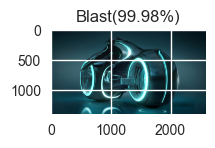

In [55]:
import cv2
import numpy as np

img=cv2.imread("D:/invalid.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_resized=cv2.resize(img, (img_width, img_height))
image=np.expand_dims(img_resized,axis=0)
#print(image.shape)

# prediction = trained_model.model.predict(image)
prediction = new_model.predict(image)
#print(prediction)

class_output = class_list[np.argmax(prediction)]
#print(class_output)

accuracy = np.array(prediction[0])[np.argmax(prediction)]
predicted_acuracy = ("{:.2%}".format(accuracy))
print(predicted_acuracy)

if(accuracy * 100 < 75):
    class_output = "Invalid Image!"
    print(class_output, " try to test another image.")

plt.figure(figsize = (2,2))
plt.imshow(img)
plt.title(class_output + "(" + predicted_acuracy + ")")
plt.show()